In [1]:
from pydicom import dcmread 
import os
from icecream import ic
import numpy as np
import matplotlib.pyplot as plt

dicom_case_dir = '../Dataset/Images'
patient_dict = {}
# Relevant metadata fields:
tags = ['PatientID','PatientName','PatientsBirthTime','PatientSex', 'PatientAge']
# Get dicom files for all cases in the dataset.
for subdir in sorted(os.listdir(dicom_case_dir)):
    # Mac creates a .DS_Store file in each directory. Ignore it.
    if subdir.startswith('.'):
        continue
    
    # Get case ID from the directory name.
    case_id = subdir.split('_')[-1]
    print(f'***** Case ID = {case_id} *****')
    subdir_path = os.path.join(dicom_case_dir, subdir)
    
    # Fetch all dicom files in the directory.
    list_files = [file_name for file_name in os.listdir(subdir_path) if not file_name.startswith('.')]
    
    # Use the first dcm file to get the metadata.
    dicom_file = os.path.join(subdir_path,list_files[0]) #choose any file print(dicom_file)
    metadata = dcmread(dicom_file)
    
    # Make sure patient identity is removed
    assert metadata['PatientIdentityRemoved'].value == 'YES', 'Patient identity not removed'
     
    # Print the relevant patient and scanner metadata.
    for tag in tags:
        try:
            print(f'{tag}: {metadata[tag].value}')
        except:
            print(f'{tag}: Not available')
            
    # Fetch the voxel metadata.
    voxel_size = metadata.PixelSpacing
    slice_thickness = metadata.SliceThickness
    orientation = metadata.ImageOrientationPatient
    rescale_intercept = metadata.RescaleIntercept
    rescale_slope = metadata.RescaleSlope
    patient_position = metadata.PatientPosition
    pixel_array_shape = metadata.pixel_array.shape
    
    # Add the metadata to the dictionary.
    patient_dict[case_id] = {'voxel_size': voxel_size, 'slice_thickness': slice_thickness, 'orientation': orientation,
                             'rescale_intercept': rescale_intercept, 'rescale_slope': rescale_slope, 'patient_position': patient_position,
                                'pixel_array_shape': pixel_array_shape}
    

***** Case ID = 000 *****
PatientID: Case_000
PatientName: Case_000
PatientsBirthTime: Not available
PatientSex: M
PatientAge: Not available
***** Case ID = 001 *****
PatientID: Case_001
PatientName: Case_001
PatientsBirthTime: Not available
PatientSex: M
PatientAge: Not available
***** Case ID = 002 *****
PatientID: Case_002
PatientName: Case_002
PatientsBirthTime: Not available
PatientSex: M
PatientAge: Not available
***** Case ID = 003 *****
PatientID: Case_003
PatientName: Case_003
PatientsBirthTime: Not available
PatientSex: F
PatientAge: Not available
***** Case ID = 004 *****
PatientID: Case_004
PatientName: Case_004
PatientsBirthTime: Not available
PatientSex: F
PatientAge: Not available
***** Case ID = 005 *****
PatientID: Case_005
PatientName: Case_005
PatientsBirthTime: Not available
PatientSex: M
PatientAge: Not available
***** Case ID = 006 *****
PatientID: Case_006
PatientName: Case_006
PatientsBirthTime: Not available
PatientSex: M
PatientAge: Not available
***** Case ID

In [2]:
voxel_sizes = set([tuple(patient_dict[case_id]['voxel_size']) for case_id in patient_dict])
slice_thicknesses = set([patient_dict[case_id]['slice_thickness'] for case_id in patient_dict])
orientations = set([tuple(patient_dict[case_id]['orientation']) for case_id in patient_dict])
rescale_intercepts = set([patient_dict[case_id]['rescale_intercept'] for case_id in patient_dict])
rescale_slopes = set([patient_dict[case_id]['rescale_slope'] for case_id in patient_dict])
patient_positions = set([patient_dict[case_id]['patient_position'] for case_id in patient_dict])

print('***** Voxel Metadata Consistency Check *****')
print(f'Voxel sizes: {voxel_sizes}')
print(f'Slice thicknesses: {slice_thicknesses}')
print(f'Orientation: {orientations}')
print(f'Rescale intercept: {rescale_intercepts}')
print(f'Rescale slope: {rescale_slopes}')
print(f'Patient position: {patient_positions}')
print(f'Pixel array shape: {pixel_array_shape}')


***** Voxel Metadata Consistency Check *****
Voxel sizes: {('0.9765625', '0.9765625')}
Slice thicknesses: {'3.0'}
Orientation: {('1.0', '0.0', '0.0', '0.0', '1.0', '0.0')}
Rescale intercept: {'-1024.0', '-1000.0'}
Rescale slope: {'1.0'}
Patient position: {'HFS'}
Pixel array shape: (512, 512)


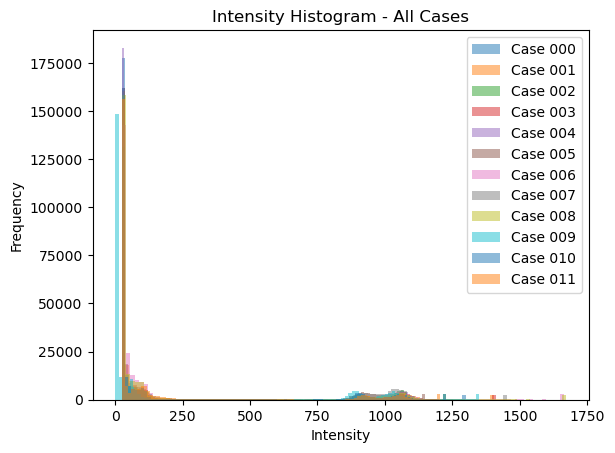

In [19]:
# Plot intensity histograms for all cases.
import matplotlib.pyplot as plt
import numpy as np

for case_id in patient_dict:
    subdir_path = os.path.join(dicom_case_dir, f'Case_{case_id}')
    list_files = [file_name for file_name in os.listdir(subdir_path) if not file_name.startswith('.')]
    dicom_file = os.path.join(subdir_path, list_files[0])
    metadata = dcmread(dicom_file)
    pixel_array = metadata.pixel_array
    winsorised_pixel_array = np.clip(pixel_array, np.percentile(pixel_array, 1), np.percentile(pixel_array, 99))
    plt.hist(np.ravel(winsorised_pixel_array), bins=100, alpha=0.5, label=f'Case {case_id}')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title(f'Intensity Histogram - All Cases')
plt.legend()
plt.savefig('intensity_histogram_orig.png', dpi=300, bbox_inches='tight')
# plt.yscale('log')
plt.show()



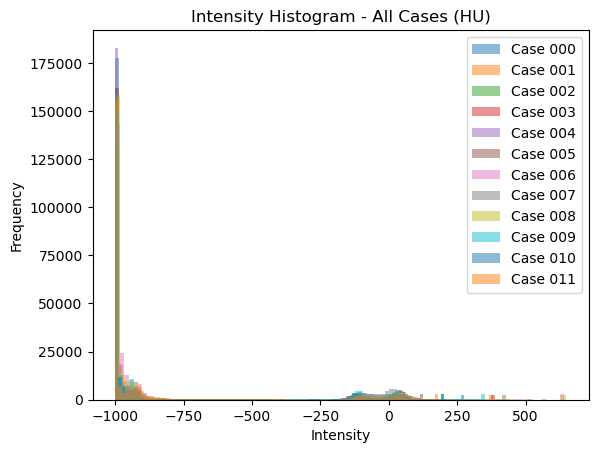

In [3]:

for case_id in patient_dict:
    subdir_path = os.path.join(dicom_case_dir, f'Case_{case_id}')
    list_files = [file_name for file_name in os.listdir(subdir_path) if not file_name.startswith('.')]
    dicom_file = os.path.join(subdir_path, list_files[0])
    metadata = dcmread(dicom_file)
    # Convert to Hounsfield units.
    pixel_array = metadata.pixel_array
    rescale_intercept = metadata.RescaleIntercept
    rescale_slope = metadata.RescaleSlope
    pixel_array_hu = pixel_array * rescale_slope + rescale_intercept
    winsorised_pixel_array = np.clip(pixel_array_hu, np.percentile(pixel_array_hu, 1), np.percentile(pixel_array_hu, 99))
    plt.hist(np.ravel(winsorised_pixel_array), bins=100, alpha=0.5, label=f'Case {case_id}')
    
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title(f'Intensity Histogram - All Cases (HU)')
plt.legend()
plt.savefig('intensity_histogram_hu.png',dpi=300, bbox_inches='tight') 
plt.show()
    

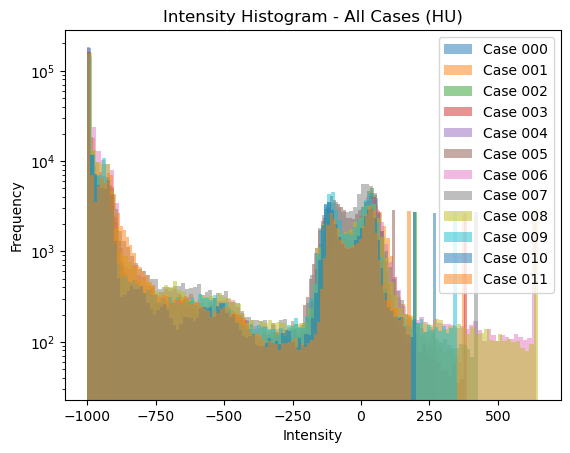

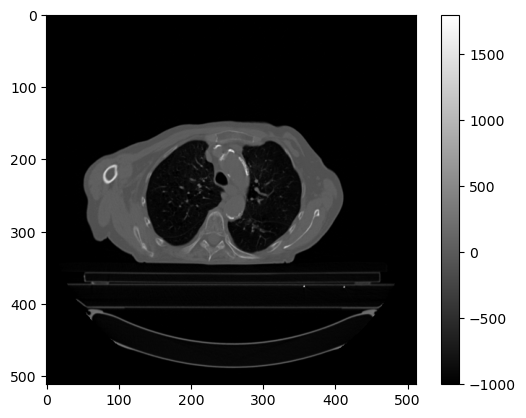

In [7]:
# Show post HU on a log scale
for case_id in patient_dict:
    subdir_path = os.path.join(dicom_case_dir, f'Case_{case_id}')
    list_files = [file_name for file_name in os.listdir(subdir_path) if not file_name.startswith('.')]
    dicom_file = os.path.join(subdir_path, list_files[0])
    metadata = dcmread(dicom_file)
    # Convert to Hounsfield units.
    pixel_array = metadata.pixel_array
    rescale_intercept = metadata.RescaleIntercept
    rescale_slope = metadata.RescaleSlope
    pixel_array_hu = pixel_array * rescale_slope + rescale_intercept
    winsorised_pixel_array = np.clip(pixel_array_hu, np.percentile(pixel_array_hu, 1), np.percentile(pixel_array_hu, 99))
    plt.hist(np.ravel(winsorised_pixel_array), bins=100, alpha=0.5, label=f'Case {case_id}')

plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title(f'Intensity Histogram - All Cases (HU)')
plt.legend()
plt.yscale('log')
plt.savefig('intensity_histogram_hu_log.png',dpi=300, bbox_inches='tight') 
plt.show()

plt.imshow(pixel_array_hu, cmap='gray')
plt.colorbar()
plt.show()

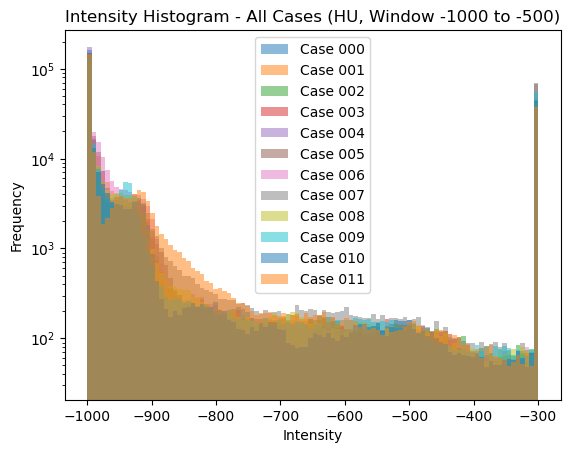

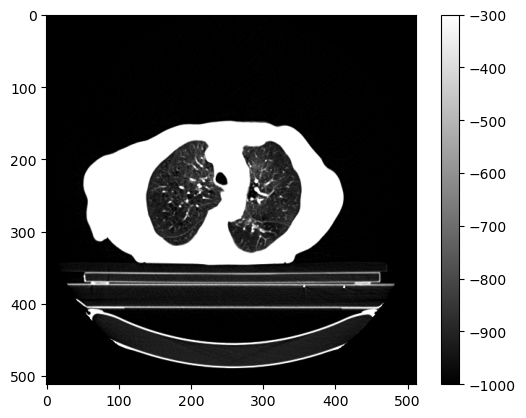

In [11]:
# Window between -1000 and -500 HU

for case_id in patient_dict:
    subdir_path = os.path.join(dicom_case_dir, f'Case_{case_id}')
    list_files = [file_name for file_name in os.listdir(subdir_path) if not file_name.startswith('.')]
    dicom_file = os.path.join(subdir_path, list_files[0])
    metadata = dcmread(dicom_file)
    # Convert to Hounsfield units.
    pixel_array = metadata.pixel_array
    rescale_intercept = metadata.RescaleIntercept
    rescale_slope = metadata.RescaleSlope
    pixel_array_hu = pixel_array * rescale_slope + rescale_intercept
    windowed_pixel_array = np.clip(pixel_array_hu, -1000, -300)
    plt.hist(np.ravel(windowed_pixel_array), bins=100, alpha=0.5, label=f'Case {case_id}')
    
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title(f'Intensity Histogram - All Cases (HU, Window -1000 to -500)')
plt.yscale('log')
plt.legend()
plt.show()

plt.imshow(windowed_pixel_array, cmap='gray')
plt.colorbar()
plt.show()



In [3]:
from utils import make_niftis
dcm_dir = '/Users/vishaljain/mphil_medical_imaging_cw/Dataset/Images/Case_000'
seg_f = '/Users/vishaljain/mphil_medical_imaging_cw/Dataset/Segmentations/Case_000_seg.npz'
make_niftis(dcm_dir, seg_f, '/Users/vishaljain/mphil_medical_imaging_cw/niftis/case_0')

In [2]:
!pip install torch

  Using cached torch-2.2.2-cp311-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.2.2-cp311-none-macosx_11_0_arm64.whl (59.7 MB)
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
